In [17]:
include("../code/bp_full_gfq.jl")

gfmult (generic function with 2 methods)

In [3]:
function iteration_saveall!(bp::BPFull{F,SVector{Q,T}}; maxiter=10^3, tol=1e-12, 
        damp=0.0, rein=0.0, 
        update_f! = update_factor_bp!, update_v! = update_var_bp!,
        factor_neigs = [nonzeros(bp.X)[nzrange(bp.X, a)] for a = 1:size(bp.H,1)],
        gftab = gftables(Val(getQ(bp))), uaux=fill(zero(MVector{Q,T}),nfactors(bp)),
        parities=zeros(Int, maxiter), dist=zeros(maxiter), s=argmax.(bp.efield),
        callback=(it, ε, bp)->false) where {F,Q,T}

    Ht = permutedims(bp.H)

    ε = 0.0
    m,n = size(bp.H)
    for it = 1:maxiter
        ε = 0.0
        # for i = 1:size(bp.H,2)
        for i = rand(1:n, n÷3*2) 
            errv = update_v!(bp, i, damp=damp, rein=rein)
            errv == Inf && @warn "Contradiction found updating var $i"
            ε = max(ε, errv)
        end
        # for a = 1:size(bp.H,1)
        for a = rand(1:m, m÷3*2)
            errf = update_f!(bp, a, gftab..., factor_neigs[a], uaux=uaux[a], 
                damp=damp)
            ε = max(ε, errf)
        end
        x = argmax.(bp.belief)
        parities[it] = parity(bp, x, Ht)
        dist[it] = distortion(x,s,getQ(bp))
        callback(it, ε, bp) && return ε,it
        ε < tol && return ε, it
    end
    ε, maxiter
end

# alias for calling `iteration_saveall!` with maxsum updates
function iteration_ms_saveall!(ms::BPFull{F,SVector{Q,T}}; update_f! = update_factor_ms_quick!,
        update_v! = update_var_ms_quick!, kw...) where {F,Q,T}
    iteration_saveall!(ms; update_f! = update_f!, update_v! = update_v!, kw...)
end

iteration_ms_saveall! (generic function with 1 method)

## Compare with RS

In [165]:
include("../code/bp_full_gfq.jl")
using DelimitedFiles
dd = readdlm("gfq.txt")
Ds = [dd[r,:] for r in 1:size(dd,1)-1]
Rs = dd[end,:];

In [166]:
k = 4
Q = 2^k
n = 300
R = Rs[85]
A = cycle_code(Q, n, R; rng=MersenneTwister(4))
s = rand(1:Q, n);

In [167]:
maxiter = 10^4
rein = 5/maxiter
ms = ms_full_gfq(A, Q, s)
gftab = gftables(Val(Q));

In [168]:
err,iters = iteration_ms!(ms, maxiter=maxiter, rein=rein, gftab=gftab)

(5.88946047630479e14, 10000)

In [169]:
nunsat, dist = performance(ms, s)

(0, 0.0275)

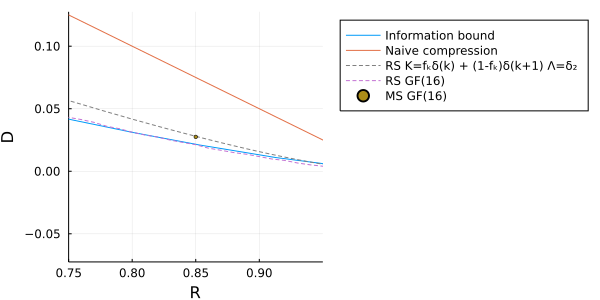

In [170]:
plot_rdb()
plot!(Rs, Ds[k], label="RS GF($Q)", line=:dash)
scatter!([R], [dist], label="MS GF($Q)", ms=2)
plot!(size=(600,300), xlims=(R-0.1,R+0.1), ylims=(dist-0.1,dist+0.1), legend=:outertopright)

## MS

In [7]:
include("../code/bp_full_gfq.jl")

fix_indep! (generic function with 2 methods)

In [10]:
Q = 4
n = 3000
R = 0.4
A = cycle_code(Q, n, R; rng=MersenneTwister(1))
s = rand(1:Q, n);

In [11]:
B, indep = findbasis_slow(A, Q);

In [12]:
maxiter = 10^3
rein = 5/maxiter
ms = ms_full_gfq(A, Q, s)
gftab = gftables(Val(Q));

In [13]:
cb(it,b,c) = (flush(stdout); println("Iter ", it); false)
factor_neigs = [nonzeros(ms.X)[nzrange(ms.X, a)] for a = 1:size(ms.H,1)]
uaux=fill(zero(MVector{Q}),nfactors(ms));

In [14]:
iteration_ms_quick!(ms, maxiter=maxiter, rein=rein, #callback=cb, 
    gftab=gftab, factor_neigs=factor_neigs, uaux=uaux)

(1.4584695335606775e9, 1000)

In [15]:
performance(ms, s)

(1, 0.177)

In [18]:
parity(ms, x .+ 1)

0

In [23]:
y = argmax.(ms.belief) 
x = y .- 1
fix_indep!(x, B, indep, Q)
y .= x .+ 1
@assert parity(ms, y) == 0

In [29]:
distortion(y, s, Q)

0.181

In [43]:
parities=zeros(Int, maxiter)
dist=zeros(maxiter)
ms = ms_full_gfq(A, Q, s)
iteration_ms_saveall!(ms, maxiter=maxiter, rein=rein, parities=parities, dist=dist, s=s,
    update_f! = update_factor_ms!, update_v! = update_var_ms_quick!, uaux = fill(-Inf*ones(MVector{Q}), nfactors(ms)))

LoadError: UndefVarError: iteration_ms_saveall! not defined

In [44]:
p1 = plot(parities, xlabel="iter", label="Nunsat")
minp = minimum(parities)
hline!(p1, [minp], label="min=$(Int(minp))")
hline!(p1, [0], label="zero")
p2 = plot(dist, xlabel="iter", label="distortion", legend=:bottomright)
plot(p1,p2, size=(900,300), margin=5Plots.mm)

LoadError: UndefVarError: F not defined

In [24]:
nunsat,d = performance(ms, s)

(9, 0.04583333333333333)

In [25]:
i = argmin(parities)
d = dist[i]

0.0425

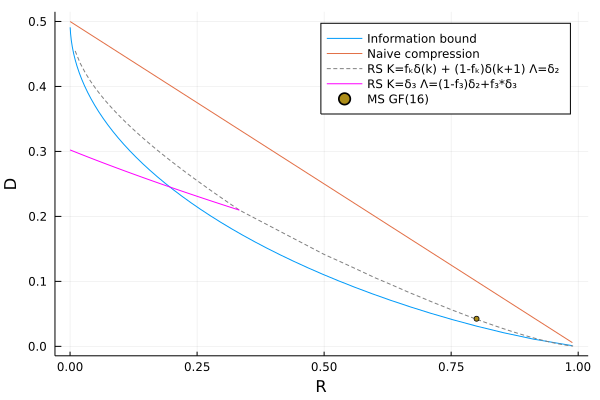

In [26]:
plot_rdb()
scatter!([R], [d], label="MS GF($Q)", ms=3)

## BP

In [138]:
Q = 4
n = 300
R = 0.5
rng = MersenneTwister(1)
A = cycle_code(Q, n, R, rng=rng)
s = rand(1:Q, n)
H = 10;

In [139]:
include("../code/bp_full_gfq.jl")

gftables (generic function with 7 methods)

In [140]:
maxiter = 10^4
rein = 5/maxiter
parities=fill(NaN, maxiter)
dist=fill(NaN,maxiter)
bp = bp_full_gfq(A, Q, s, H);
gfmult, gfdiv = gftables(Val(Q));

In [141]:
bp_slow = deepcopy(bp)
iteration!(bp_slow, maxiter=maxiter, rein=rein)

(9.414691248821327e-14, 853)

In [142]:
performance(bp_slow, s)

(2, 0.13166666666666665)

In [143]:
bp_quick = deepcopy(bp)
iteration_bp_quick!(bp_quick, maxiter=maxiter, rein=rein)

(2.240716371341093e-14, 1069)

In [144]:
performance(bp_quick, s)

(2, 0.13166666666666665)

In [145]:
iteration_saveall!(bp, damp=0.0, maxiter=maxiter, rein=rein, parities=parities, dist=dist, s=s, tol=0)

(0.0002240592884743542, 10000)

In [146]:
x = argmax.(bp.belief)
parity(bp, x)

2

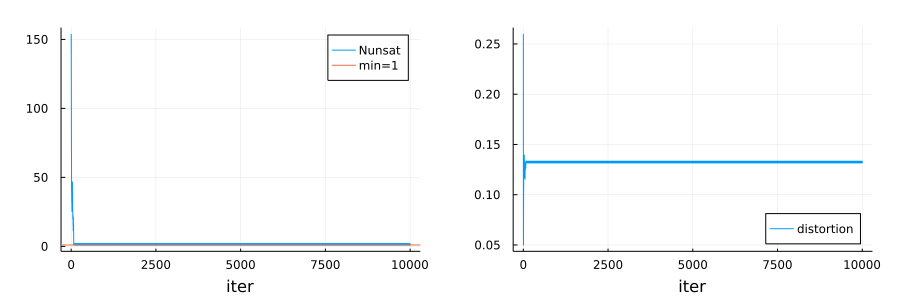

In [147]:
p1 = plot(parities, xlabel="iter", label="Nunsat")
minp = minimum(parities)
hline!(p1, [minp], label="min=$(Int(minp))")
p2 = plot(dist, xlabel="iter", label="distortion", legend=:bottomright)
plot(p1,p2, size=(900,300), margin=5Plots.mm)

In [148]:
nunsat,dist = performance(bp,s)

(2, 0.13333333333333333)

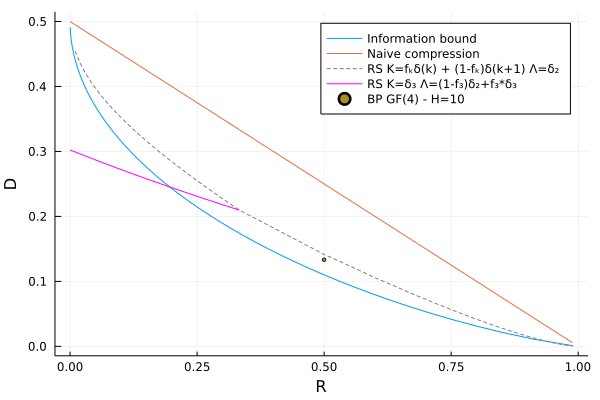

In [149]:
plot_rdb()
scatter!([R], [dist], label="BP GF($Q) - H=$H", ms=2)

## Varying the rate

In [54]:
include("../code/bp_full_gfq.jl")

In [71]:
Rs = 0.2:0.1:0.8
navg = 10
d = [fill(NaN,navg) for r in Rs]
maxiter = 2*10^4
rein = 5/maxiter
damp = 0.0
k = 4
Q = 2^k
n = 600
rng = MersenneTwister(0)
gftab = gftables(Val(Q));

In [72]:
@telegram "GF(q)" for (i,R) in pairs(Rs)
    println("### Rate $i of ", length(Rs), " ###")
    for j in 1:navg
        rng = MersenneTwister(j)
        A = cycle_code(Q, n, R, maxtrials=10^4, rng=rng)
        s = rand(1:Q, n)
        ms = ms_full_gfq(A, Q, s)
        ε, iters = iteration_ms_quick!(ms, maxiter=maxiter, rein=rein)
        x = argmax.(ms.belief)
        p = parity(ms, x)
        println("Avg $j of $navg: parity ", p)
        d[i][j] = distortion(x, s, Q)
        if p != 0
            B, indep = findbasis_slow(A, Q, gftab=gftab)
            y = x .- 1
            fix_indep!(y, B, indep, Q)
            d[i][j] = distortion(y .+ 1, s, Q)
        end
    end
end

### Rate 1 of 4 ###
Avg 1 of 10: parity 8
Avg 2 of 10: parity 1
Avg 3 of 10: parity 2
Avg 4 of 10: parity 5
Avg 5 of 10: parity 4
Avg 6 of 10: parity 0
Avg 7 of 10: parity 4
Avg 8 of 10: parity 4
Avg 9 of 10: parity 11
Avg 10 of 10: parity 5
### Rate 2 of 4 ###
Avg 1 of 10: parity 2
Avg 2 of 10: parity 3
Avg 3 of 10: parity 2
Avg 4 of 10: parity 7
Avg 5 of 10: parity 8
Avg 6 of 10: parity 9
Avg 7 of 10: parity 11
Avg 8 of 10: parity 3
Avg 9 of 10: parity 5
Avg 10 of 10: parity 1
### Rate 3 of 4 ###
Avg 1 of 10: parity 2
Avg 2 of 10: parity 6
Avg 3 of 10: parity 3
Avg 4 of 10: parity 9
Avg 5 of 10: parity 1
Avg 6 of 10: parity 3
Avg 7 of 10: parity 6
Avg 8 of 10: parity 7
Avg 9 of 10: parity 5
Avg 10 of 10: parity 0
### Rate 4 of 4 ###
Avg 1 of 10: parity 0
Avg 2 of 10: parity 11
Avg 3 of 10: parity 2
Avg 4 of 10: parity 1
Avg 5 of 10: parity 7
Avg 6 of 10: parity 13
Avg 7 of 10: parity 3
Avg 8 of 10: parity 4
Avg 9 of 10: parity 7
Avg 10 of 10: parity 2


In [73]:
d

4-element Vector{Vector{Float64}}:
 [0.2841666666666667, 0.27625, 0.27166666666666667, 0.28375, 0.27416666666666667, 0.2625, 0.30041666666666667, 0.2833333333333333, 0.30333333333333334, 0.28041666666666665]
 [0.17, 0.17916666666666667, 0.1775, 0.17458333333333334, 0.18416666666666667, 0.18083333333333335, 0.17875, 0.1825, 0.1825, 0.16541666666666666]
 [0.105, 0.10791666666666666, 0.10166666666666667, 0.11958333333333333, 0.10875, 0.12375, 0.12333333333333334, 0.1125, 0.10541666666666667, 0.09458333333333334]
 [0.03875, 0.058333333333333334, 0.05125, 0.04666666666666667, 0.05583333333333333, 0.055, 0.04666666666666667, 0.05125, 0.05708333333333333, 0.050416666666666665]

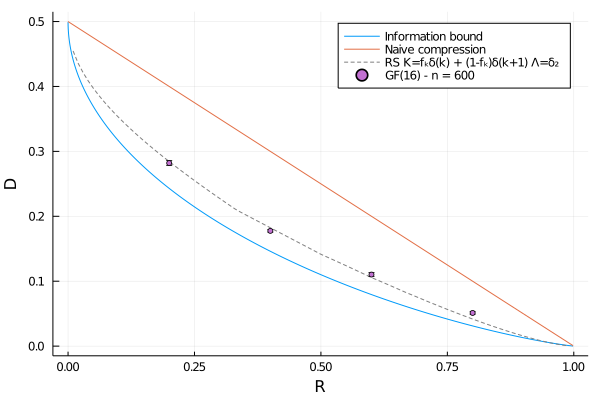

In [74]:
pl = plot_rdb()
scatter!(pl, Rs, mean.(d), label="GF($Q) - n = $n", ms=3, yerr=std.(d)./sqrt(navg))

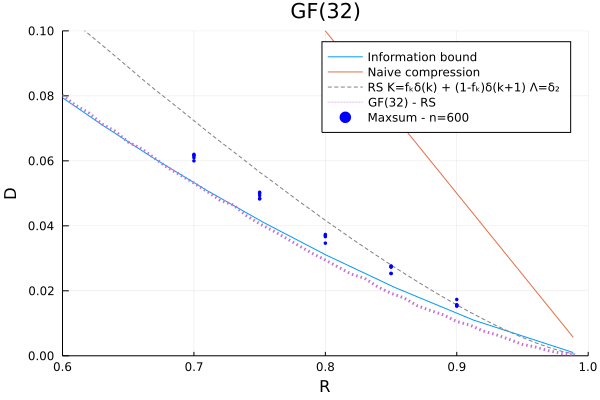

In [223]:
pl = plot_rdb()
plot!(pl, rs, d[k], ls=:dot, label="GF($Q) - RS", lw=3)
for (i,R) in pairs(Rs)
    idx = .!isnan.(d[i])
    scatter!(pl, R*ones(navg)[idx], d[i][idx], label=i==1 ? "Maxsum - n=600" : "", ms=2, c=:blue, msw=0)
end
title!(pl, "GF($Q)")
xlims!((minimum(Rs)-0.1,maximum(Rs)+0.1)); ylims!((0,0.1))
pl

In [200]:
f = readdlm("gfq.txt")
ff = [f[r,:] for r in 1:size(f,1)]
rs = ff[end]
ds = ff[1:end-1];

In [212]:
Rs = 0.7:0.05:0.9
navg = 5
d2 = [fill(NaN,navg) for r in Rs]
maxiter = 2*10^4
rein = 5/maxiter
damp = 0.0
maxtrials = 10
k = 5
Q = 2^k
n = 1200;

In [213]:
@showprogress for (i,R) in pairs(Rs)
    for j in 1:navg
        converged = false
        for t in 1:maxtrials
            A = cycle_code(Q, n, R, maxtrials=10^4)
            s = rand(1:Q, n)
            ms = ms_full_gfq(A, Q, s)
            ε, iters = iteration_ms_quick!(ms, maxiter=maxiter, rein=rein)
            x = argmax.(ms.belief)
            p = parity(ms, x)
            if p == 0
                d2[i][j] = distortion(x, s, Q)
                converged = true
                println("R=$R, avg $j, converged at trial $t")
                flush(stdout)
                break
            end
        end
    end
end

R=0.7, avg 2, converged at trial 4
R=0.7, avg 3, converged at trial 3
R=0.7, avg 4, converged at trial 2
R=0.7, avg 5, converged at trial 5


Progress:  20%|████████▎                                |  ETA: 5:07:52

R=0.75, avg 1, converged at trial 10
R=0.75, avg 2, converged at trial 7
R=0.75, avg 3, converged at trial 2
R=0.75, avg 4, converged at trial 1
R=0.75, avg 5, converged at trial 4


Progress:  40%|████████████████▍                        |  ETA: 3:57:44

R=0.8, avg 1, converged at trial 7
R=0.8, avg 2, converged at trial 2
R=0.8, avg 3, converged at trial 2
R=0.8, avg 4, converged at trial 1
R=0.8, avg 5, converged at trial 1


Progress:  60%|████████████████████████▋                |  ETA: 2:13:26

R=0.85, avg 1, converged at trial 3
R=0.85, avg 2, converged at trial 3
R=0.85, avg 3, converged at trial 5
R=0.85, avg 5, converged at trial 3


Progress:  80%|████████████████████████████████▊        |  ETA: 1:09:20

R=0.9, avg 1, converged at trial 1
R=0.9, avg 2, converged at trial 3
R=0.9, avg 3, converged at trial 1
R=0.9, avg 4, converged at trial 8
R=0.9, avg 5, converged at trial 3


Progress: 100%|█████████████████████████████████████████| Time: 5:29:48


In [216]:
d2

5-element Vector{Vector{Float64}}:
 [NaN, 0.06133333333333333, 0.06166666666666667, 0.06, 0.06083333333333333]
 [0.04783333333333333, 0.049666666666666665, 0.051000000000000004, 0.049666666666666665, 0.048]
 [0.036, 0.035833333333333335, 0.03666666666666667, 0.035666666666666666, 0.0375]
 [0.025500000000000002, 0.026000000000000002, 0.025, NaN, 0.026166666666666664]
 [0.016166666666666666, 0.016166666666666666, 0.016166666666666666, 0.015333333333333332, 0.01633333333333333]

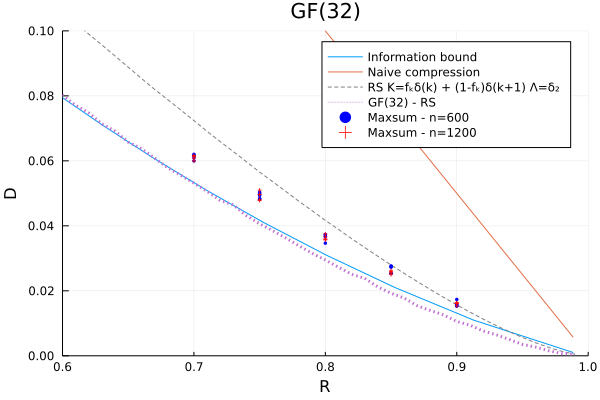

In [224]:
pl2 = deepcopy(pl)
for (i,R) in pairs(Rs)
    idx = .!isnan.(d2[i])
    scatter!(pl2, R*ones(navg)[idx], d2[i][idx], label=i==1 ? "Maxsum - n=1200" : "", ms=2, c=:red, msw=0, m=:+)
end
pl2

In [227]:
pp = plot(pl2, dpi=300)
savefig(pp, "gf32.png")

In [154]:
Rs = 0.2:0.1:0.8
navg = 5
d2 = [fill(NaN,navg) for r in Rs]
maxiter = 10^3
rein = 5/maxiter
damp = 0.0
maxtrials = 10
Q = 2
n = 1200;

In [155]:

@showprogress for (i,R) in pairs(Rs)
    for j in 1:navg
        converged = false
        for t in 1:maxtrials
            A = cycle_code(Q, n, R, rng=rng)
            s = rand(1:Q, n)
            ms = ms_full_gfq(A, Q, s)
            ε, iters = iteration_ms!(ms, damp=damp, maxiter=maxiter, rein=rein)
            x = argmax.(ms.belief)
            p = parity(ms, x)
            if p == 0
                d2[i][j] = distortion(x, s, Q)
                converged = true
                println("R=$R, avg $j, converged at trial $t")
                break
            end
        end
    end
end

R=0.2, avg 1, converged at trial 2
R=0.2, avg 2, converged at trial 2
R=0.2, avg 3, converged at trial 2
R=0.2, avg 4, converged at trial 10


Progress:  14%|█████▉                                   |  ETA: 0:01:04

R=0.2, avg 5, converged at trial 1
R=0.3, avg 1, converged at trial 3
R=0.3, avg 2, converged at trial 1
R=0.3, avg 3, converged at trial 3
R=0.3, avg 4, converged at trial 1


Progress:  29%|███████████▊                             |  ETA: 0:00:39

R=0.3, avg 5, converged at trial 1
R=0.4, avg 1, converged at trial 2
R=0.4, avg 2, converged at trial 7
R=0.4, avg 3, converged at trial 3
R=0.4, avg 4, converged at trial 2


Progress:  43%|█████████████████▋                       |  ETA: 0:00:36

R=0.4, avg 5, converged at trial 7
R=0.5, avg 1, converged at trial 9
R=0.5, avg 2, converged at trial 1
R=0.5, avg 4, converged at trial 3


Progress:  57%|███████████████████████▍                 |  ETA: 0:00:31

R=0.5, avg 5, converged at trial 7
R=0.6, avg 1, converged at trial 9
R=0.6, avg 2, converged at trial 3
R=0.6, avg 3, converged at trial 1
R=0.6, avg 4, converged at trial 6


Progress:  71%|█████████████████████████████▎           |  ETA: 0:00:21

R=0.6, avg 5, converged at trial 2
R=0.7, avg 1, converged at trial 2
R=0.7, avg 2, converged at trial 2
R=0.7, avg 3, converged at trial 1
R=0.7, avg 4, converged at trial 1


Progress:  86%|███████████████████████████████████▏     |  ETA: 0:00:09

R=0.7, avg 5, converged at trial 1
R=0.8, avg 1, converged at trial 1
R=0.8, avg 2, converged at trial 1
R=0.8, avg 3, converged at trial 1
R=0.8, avg 4, converged at trial 1


Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


R=0.8, avg 5, converged at trial 1


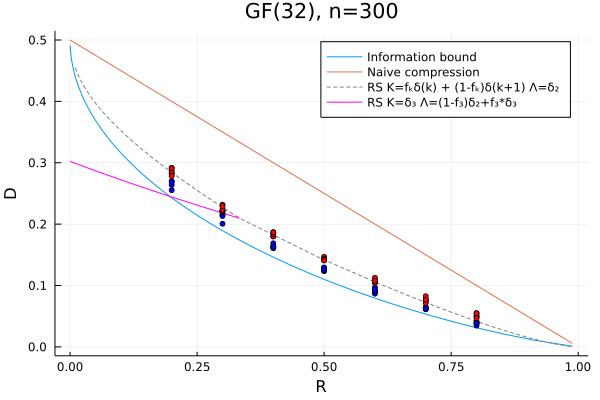

In [156]:
# pl = plot_rdb()
for (i,R) in pairs(Rs)
    idx = .!isnan.(d2[i])
    scatter!(pl, R*ones(navg)[idx], d2[i][idx], label="", ms=3, c=:red)
end
# title!(pl, "GF(2), n=$n")
pl